# CS645 Project 3 : SeeDB Implementation



**Note:**  Ensure you update the married and unmarried tables according to original adults vs all_adults table.

**Use below:**

create table unmarried_adults as select * from all_adults where marital_status ='Unmarried';
alter table unmarried_adults drop marital_status;
create table married_adults as select * from all_adults where marital_status ='Married';
alter table married_adults drop marital_status;

In [12]:
%pip install psycopg2
%pip install scipy
%pip install seaborn
import sys
import psycopg2
from scipy import stats as kl
import pandas as pd
import numpy as np
from collections import defaultdict
from math import log,pi
from decimal import Decimal
import seaborn as sns
%matplotlib inline

You are using pip version 9.0.1, however version 23.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 23.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 23.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [43]:
hostname = 'localhost'
username = 'sabareeshnikhil'
password = ''
database = 'postgres'

continuous=['model_year','range_miles']
discrete=['county','city','state_code','make','ev_type','cafv','utility']
aggregate=['sum','avg','max','min','count']

k=3
num_partitions=20
delta= 0.01

### Database connection:

In [14]:
connection = psycopg2.connect( host=hostname, user=username, password=password, dbname=database )

In [39]:
def get_all_views():
    views=[]
    for f in aggregate:
        for a in discrete:
            for m in continuous:
                views.append((a,m,f))
    return views

def get_query_result( conn, query ) :
    cur = conn.cursor()
    cur.execute( query )
    return cur

def normalize(f_list_1,f_list_2):
    sum_1=sum(f_list_1)
    sum_2=sum(f_list_2)
    norm_1 = [i/sum_1 for i in f_list_1]
    norm_2=[i/sum_2 for i in f_list_2]
    return norm_1,norm_2

def get_utility(f_list_1,f_list_2):
    nf_1,nf_2=normalize(f_list_1,f_list_2)
    nf_1=[float(x) for x in nf_1]
    nf_2=[float(x) for x in nf_2]
    return kl.entropy(nf_1,nf_2)


def get_top_k(dict_kl, k):
    return sorted(dict_kl.items(), key= lambda item: item[1], reverse=True)[:k]

def get_bottom_k(dict_kl, k):
    return sorted(dict_kl.items(), key= lambda item: item[1], reverse=False)[:k]

def get_iter(d):
    if isinstance(d,dict):
        return d.items()
    else: #cursor
        return d.fetchall()

def get_agg_lists(o_1,o_2):
    dict_res = defaultdict(list)
    f_list_1 = []
    f_list_2 = []
    for k,v in get_iter(o_1):
        if v != 0:
            dict_res[k].append(v)
        else:
            dict_res[k].append(Decimal(1e-10))
    for k,v in get_iter(o_2):
        if k not in dict_res:
            dict_res[k].append(Decimal(1e-10))
        if v != 0:
            dict_res[k].append(v)
        else:
            dict_res[k].append(Decimal(1e-10))
    for k,v in dict_res.items():
        if len(v) != 2:
            dict_res[k].append(Decimal(1e-10))
    for i in dict_res.values():
        f_list_1.append(i[0])
        f_list_2.append(i[1])
    return f_list_1,f_list_2

# Exhaustive Search:

In [53]:
dict_kl=defaultdict(list)
views=get_all_views()
for a,m,f in views:
    #print (a,f,m)
    q1='select '+a+', '+f+'('+m+') from us_ev where '+a+' is not null group by '+a+' order by '+a+';'
    q2='select '+a+', '+f+'('+m+') from non_us_ev where '+a+' is not null group by '+a+' order by '+a+';'
    res_1=get_query_result(connection, q1)
    res_2=get_query_result(connection, q2)
    f_list_1,f_list_2 = get_agg_lists(res_1,res_2)
    dict_kl[a,m,f].append(get_utility(f_list_1,f_list_2))

top_k_exhaustive_search = get_top_k(dict_kl, k)
bottom_k_exhaustive_search = get_bottom_k(dict_kl, k)

# Sharing-based Optimizations:

In [17]:
def get_combined_queries():
    discrete_list=','.join(discrete)  # a,b,c
    group_by_clause=' group by '+discrete_list  # group by a,b,c
    
    where_clause=' where '
    for a in discrete:
        where_clause+=' '+a+' is not null and'
    where_clause=where_clause[:-3] # remove last and
    
    aggregate_continuous=''
    for f in aggregate:
        for m in continuous:
            aggregate_continuous+= (','+f+'('+m+') as '+f+'_'+m)  #f1(m1) as f1_m1,f1(m2) as f1_m2..
    
    combined_queries=[]
    for table_name in ['us','non_us']:
        combined_queries.append('select '+discrete_list+aggregate_continuous+' from '+table_name+'_ev'+where_clause+group_by_clause+' ;')
    return combined_queries

def apply_func(vals, func):
    if func=='sum':
        return sum(vals)
    elif func=='max':
        return max(vals)
    elif func=='min':
        return min(vals)
    elif func=='count':
        return sum(vals)

def get_vals_avg(vals, counts):
    sum_vals = 0
    total_counts = 0
    for a_i,c_i in zip(vals, counts):
        sum_vals += a_i*c_i
        total_counts += c_i
    try:
        return sum_vals/total_counts
    except:
        return Decimal(1e-10)
    
def partition_dataframe(num_partitions, df):
    return np.array_split(df, num_partitions)


def evaluate_dataframes(df_list,views):
    dict_kl=defaultdict(list)
    for a,m,f in views:
        attr_list=[defaultdict(list), defaultdict(list)]
        for i in range(len(df_list)):
            for val in df_list[i][a].unique():  # for all unique values of an attribute
                val_list=list(df_list[i][df_list[i][a] == val]["{}_{}".format(f,m)]) #get all corresponding vals
                if f != 'avg':
                    post_func_val=apply_func(val_list,f)  # apply function f
                else:
                    val_count_list=(list(df_list[i][df_list[i][a] == val]["count_{}".format(m)]))
                    post_func_val=get_vals_avg(val_list,val_count_list)
                attr_list[i][val]=post_func_val   # associate to dict

        f_list_1,f_list_2 = get_agg_lists(attr_list[0],attr_list[1])
        dict_kl[a,m,f].append(get_utility(f_list_1,f_list_2))
    return dict_kl

In [45]:
q1,q2=get_combined_queries()  #married and unmarried 

res_1=get_query_result(connection, q1)
res_2=get_query_result(connection, q2)

df_res_1 = pd.DataFrame(res_1.fetchall())
df_res_1.columns=[desc[0] for desc in res_1.description]
df_res_2 = pd.DataFrame(res_2.fetchall())
df_res_2.columns=[desc[0] for desc in res_2.description]

dict_kl=defaultdict(list)
views=get_all_views()
df_list=[df_res_1, df_res_2]
dict_kl=evaluate_dataframes(df_list, views)

top_k_sharing = get_top_k(dict_kl,k)
bottom_k_sharing = get_bottom_k(dict_kl,k)

# Pruning & Sharing-Based Optimizations:

In [19]:
# nf- normalized scores till now.
# u- mean till now.
# m - len(scores till now)
# N- num partitions
def get_confidence(m, N, delta):
    t1=1-((m-1)/N)
    t2=2*log(log(m))
    t3=log(pi**2/(3*delta))
    numerator=t1*t2+t3
    denominator=2*m
    epsilon_m=(numerator/denominator)**0.5
    return epsilon_m

def update_stats(dict_kl):
    dict_stats=defaultdict(dict)
    for key,vals in dict_kl.items():
        dict_stats[key]['mean']=sum(vals)/len(vals)
        CI = get_confidence(len(dict_kl[key]), num_partitions, delta)
        dict_stats[key]['lower_CI'] = dict_stats[key]['mean'] - CI
        dict_stats[key]['upper_CI'] = dict_stats[key]['mean'] + CI
    return dict_stats

In [46]:
q1,q2=get_combined_queries()  #married and unmarried 

res_1=get_query_result(connection, q1)
res_2=get_query_result(connection, q2)

df_res_1 = pd.DataFrame(res_1.fetchall())
df_res_1.columns=[desc[0] for desc in res_1.description]
df_res_2 = pd.DataFrame(res_2.fetchall())
df_res_2.columns=[desc[0] for desc in res_2.description]

df_res_1_partitions=partition_dataframe(num_partitions, df_res_1)
df_res_2_partitions=partition_dataframe(num_partitions, df_res_2)

dict_list_kl=defaultdict(list)
dict_stats=defaultdict(dict)
views= get_all_views()

m=0
for i in range(num_partitions):
    df_list=[df_res_1_partitions[i],df_res_2_partitions[i]]
    partition_dict_kl=evaluate_dataframes(df_list, views)
    #add new partition KL values to already existing ones
    for key, value in partition_dict_kl.items():
        dict_list_kl[key].append(value[0])
    m+=1
    #update stats
    if m>1: # math domain error for log(1) in confidence function
        dict_stats=update_stats(dict_list_kl)  # key : {mean: _ , lower_CI:_ , upper_CI: }
        #get all lower CI's
        lower_CIs=[]
        for triple,stats in dict_stats.items():
            lower_CIs.append(stats['lower_CI'])
        lower_CIs=sorted(lower_CIs, reverse=True)
        k_lowest_CI=lower_CIs[k-1] # zero indexed
        #remove all views whose keys have a lower upper CI than that
        for view,stats in dict_stats.items():
            if stats['upper_CI']<k_lowest_CI:
                views.remove(view)
                del dict_list_kl[view]
    
dict_kl=defaultdict(list)
for key in dict_list_kl.keys():
    dict_kl[key] = dict_stats[key]['mean']

top_k_pruning_and_sharing = get_top_k(dict_kl, k)
bottom_k_pruning_and_sharing = get_bottom_k(dict_kl, k)

# Visualizing top queries

In [37]:
sns.set(style="whitegrid")
def visualize_query(a,m,f):
    q1='select '+a+', '+f+'('+m+') from us_ev where '+a+' is not null group by '+a+' order by '+a+';'
    q2='select '+a+', '+f+'('+m+') from non_us_ev where '+a+' is not null group by '+a+' order by '+a+';'
    res_1=get_query_result(connection, q1)
    res_2=get_query_result(connection, q2)
    res_1 = pd.DataFrame(res_1.fetchall(), columns=["cat","value"])
    res_2 = pd.DataFrame(res_2.fetchall(), columns=["cat","value"])
    merged_res = pd.merge(res_1, res_2, how='outer', on='cat', suffixes=['_us','_non_us'])
    merged_res.fillna("0", inplace=True)
    #print(merged_res)
    melted_merged_res = pd.DataFrame(columns=['{}'.format(a), 'US', '{}({})'.format(f.upper(),m)])
    for cat, v1, v2 in merged_res.values:
        melted_merged_res.loc[len(melted_merged_res)] = [cat,'True', int(v1)]
        melted_merged_res.loc[len(melted_merged_res)] = [cat,'False', int(v2)]
    filtered_data = melted_merged_res[melted_merged_res['{}({})'.format(f.upper(),m)] != 0]
    g = sns.catplot(x=a, y='{}({})'.format(f.upper(),m), hue="US", data=filtered_data, kind='bar', height=8, aspect=1.5)
    g.set_xticklabels(rotation=90)

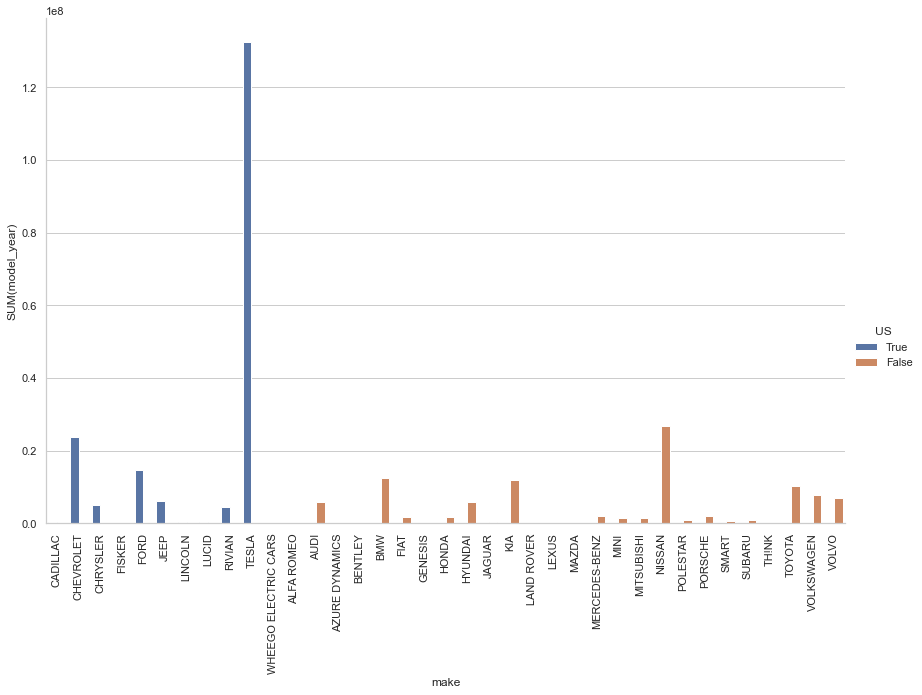

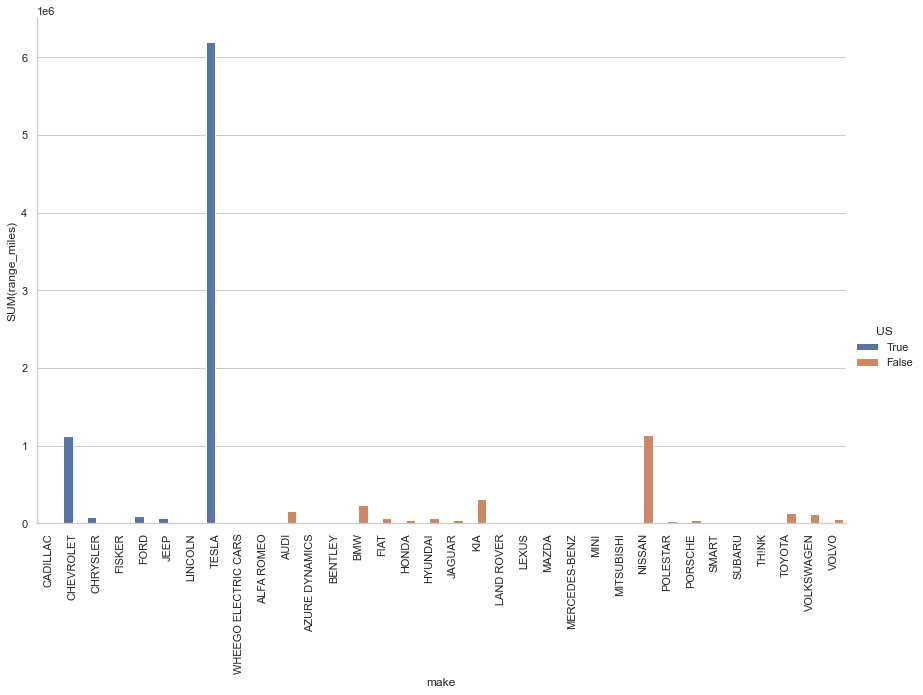

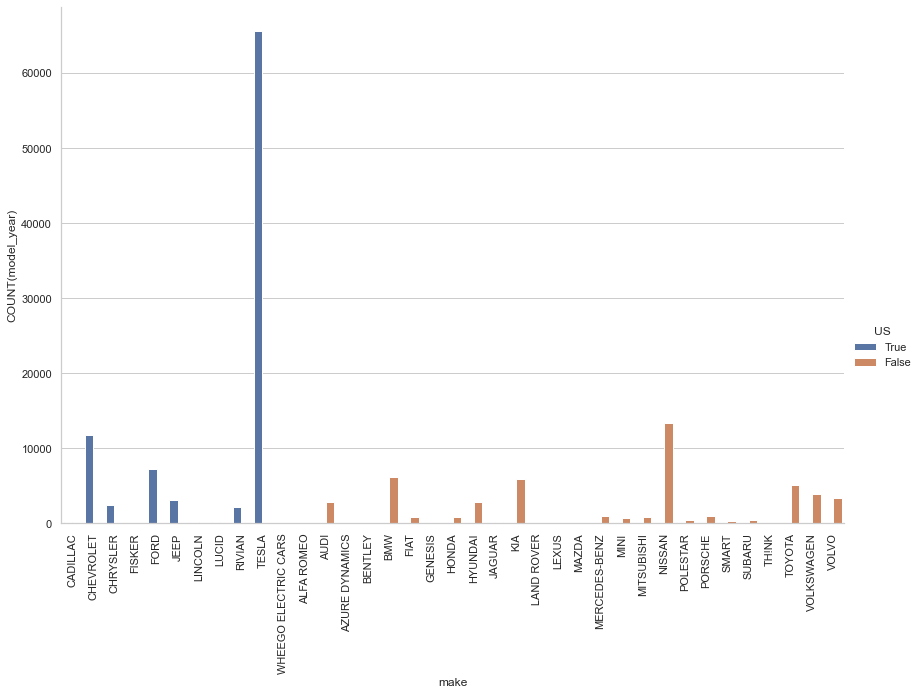

In [47]:
for q in top_k_exhaustive_search:
    a,m,f = q[0]
    visualize_query(a,m,f)

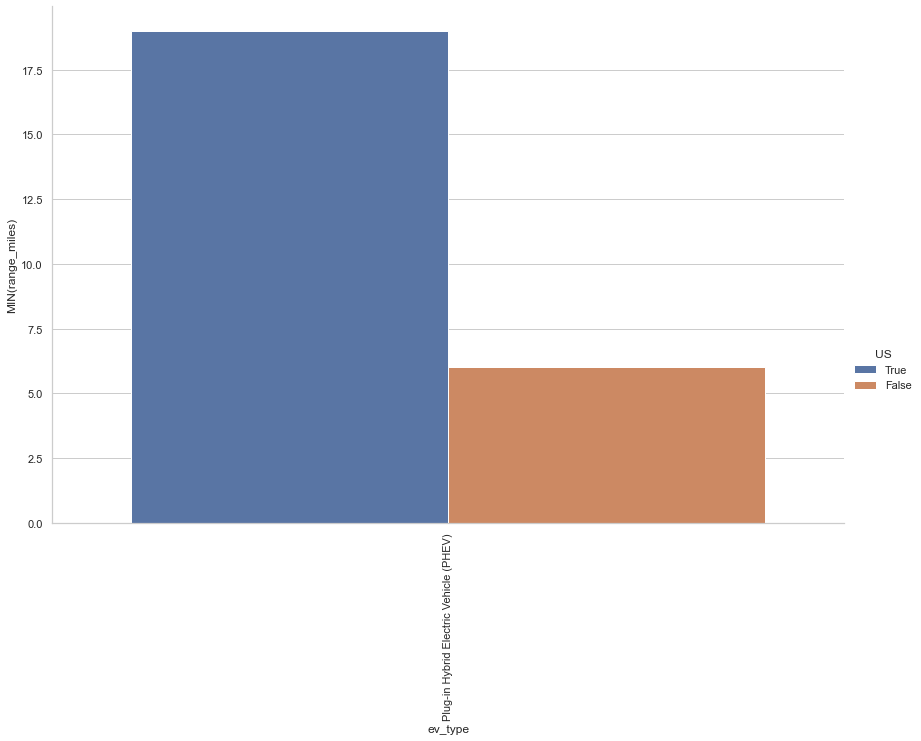

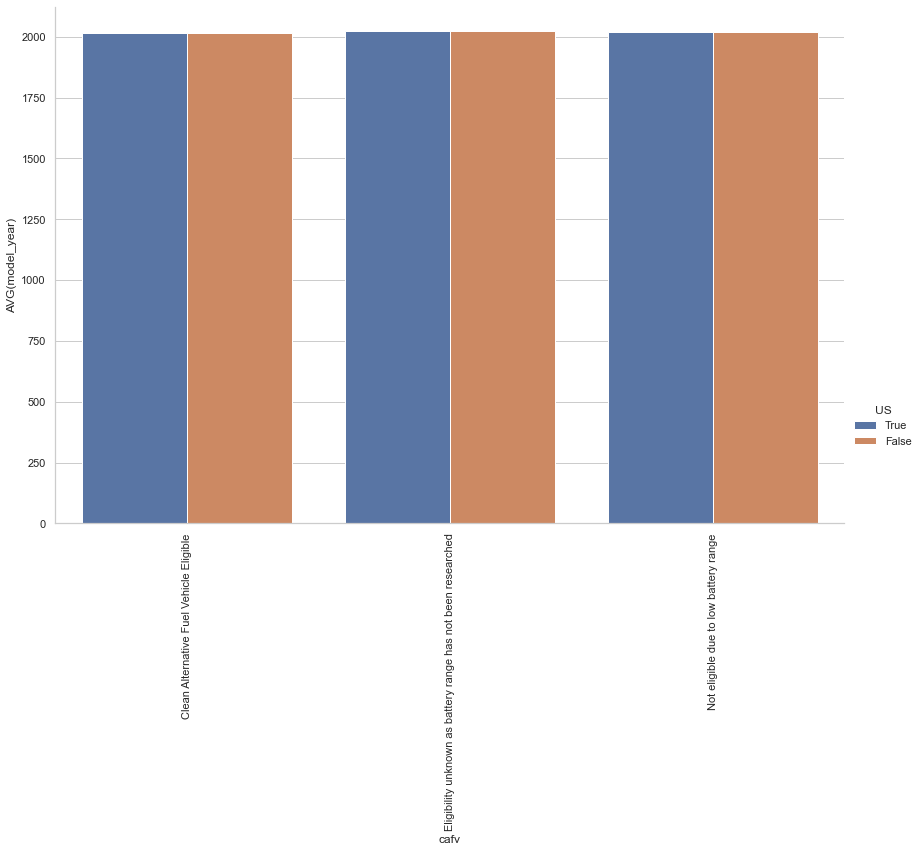

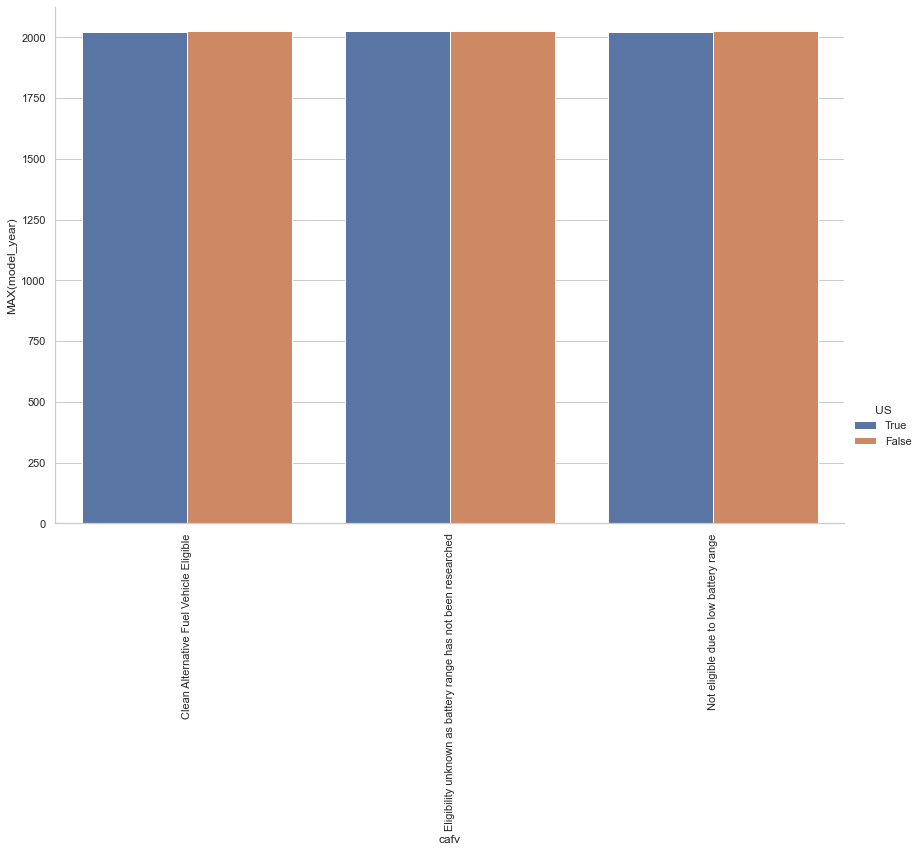

In [54]:
for q in bottom_k_exhaustive_search:
    a,m,f = q[0]
    visualize_query(a,m,f)

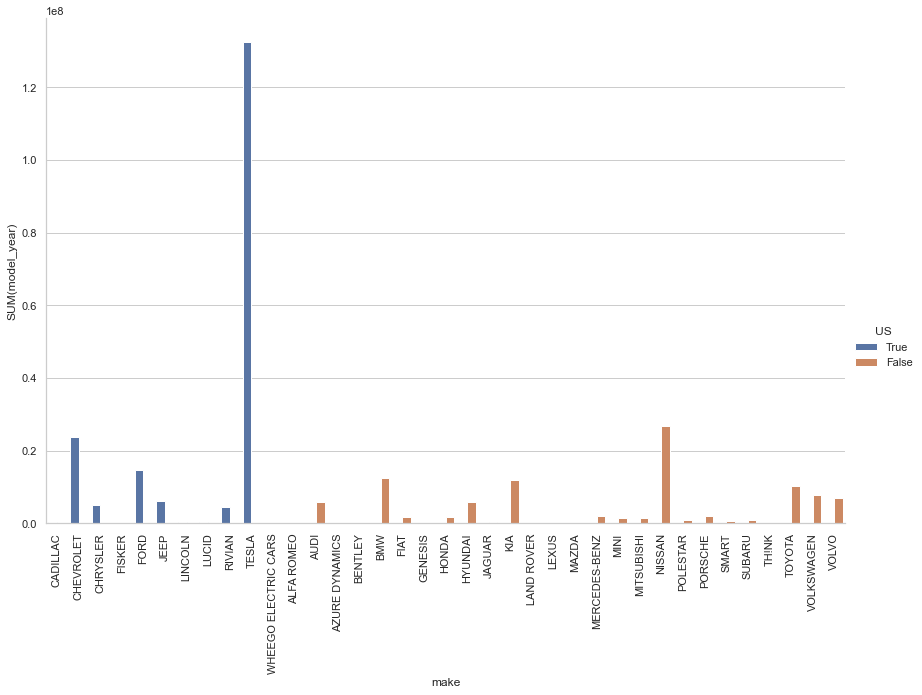

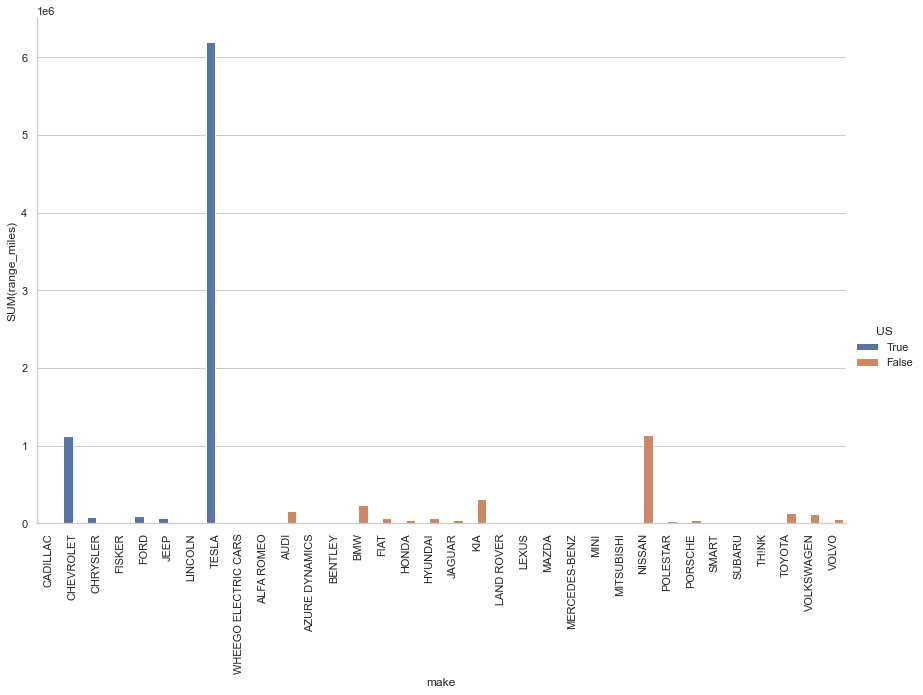

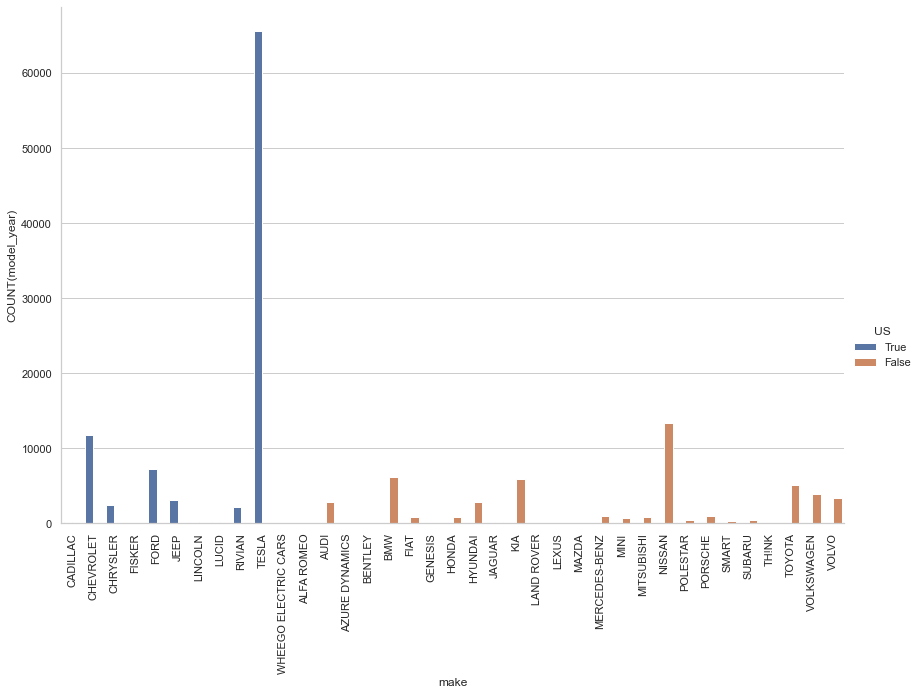

In [49]:
for q in top_k_sharing:
    a,m,f = q[0]
    visualize_query(a,m,f)

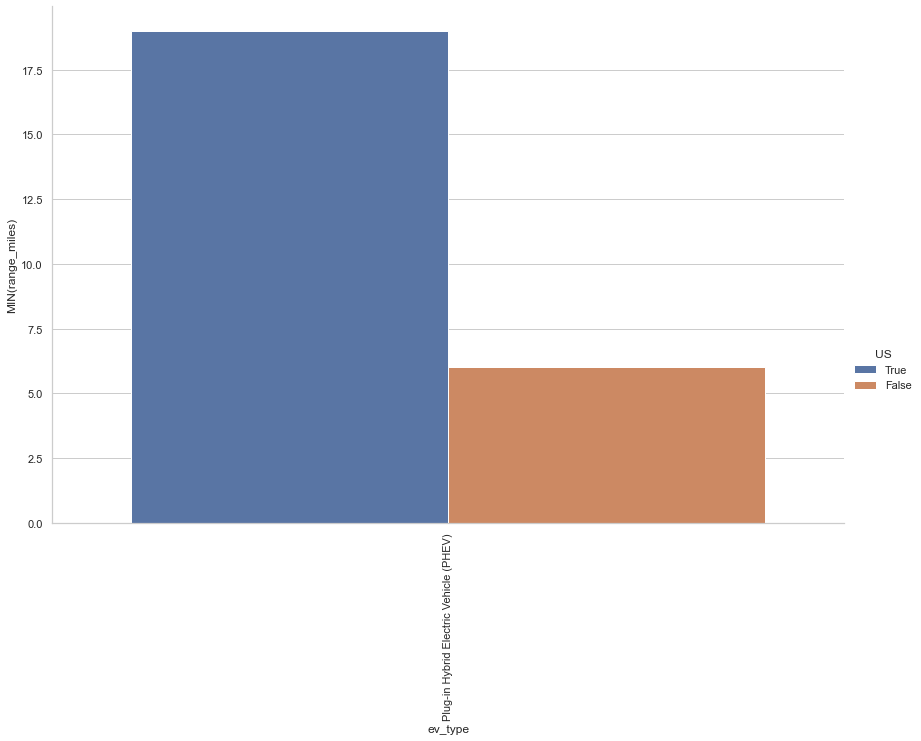

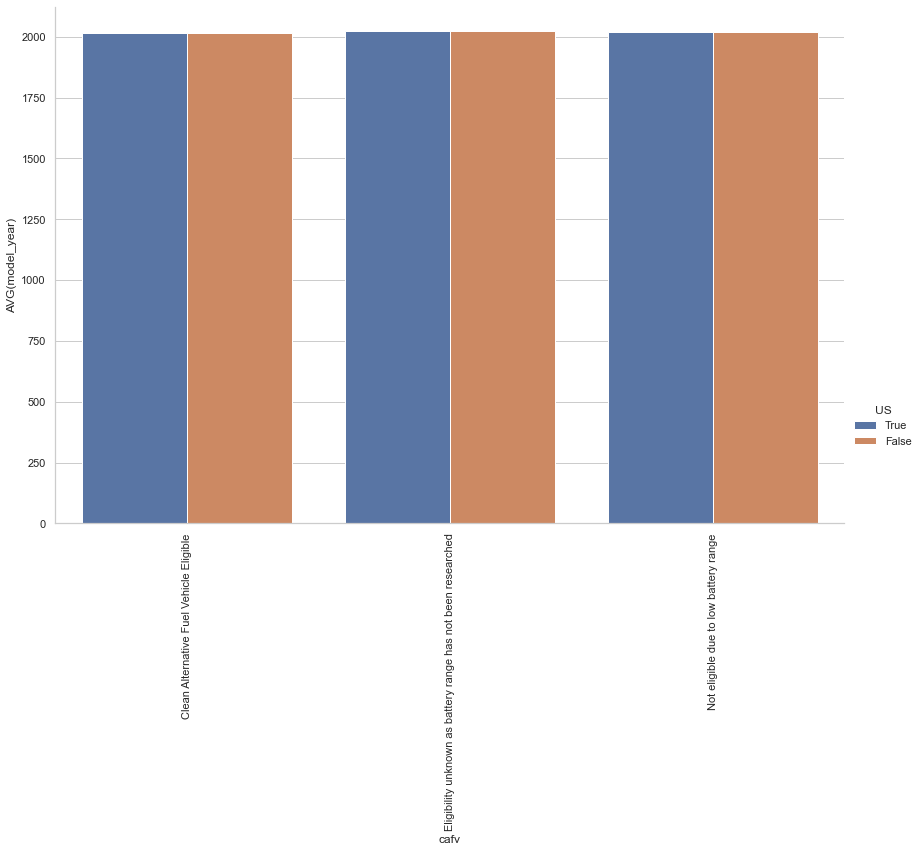

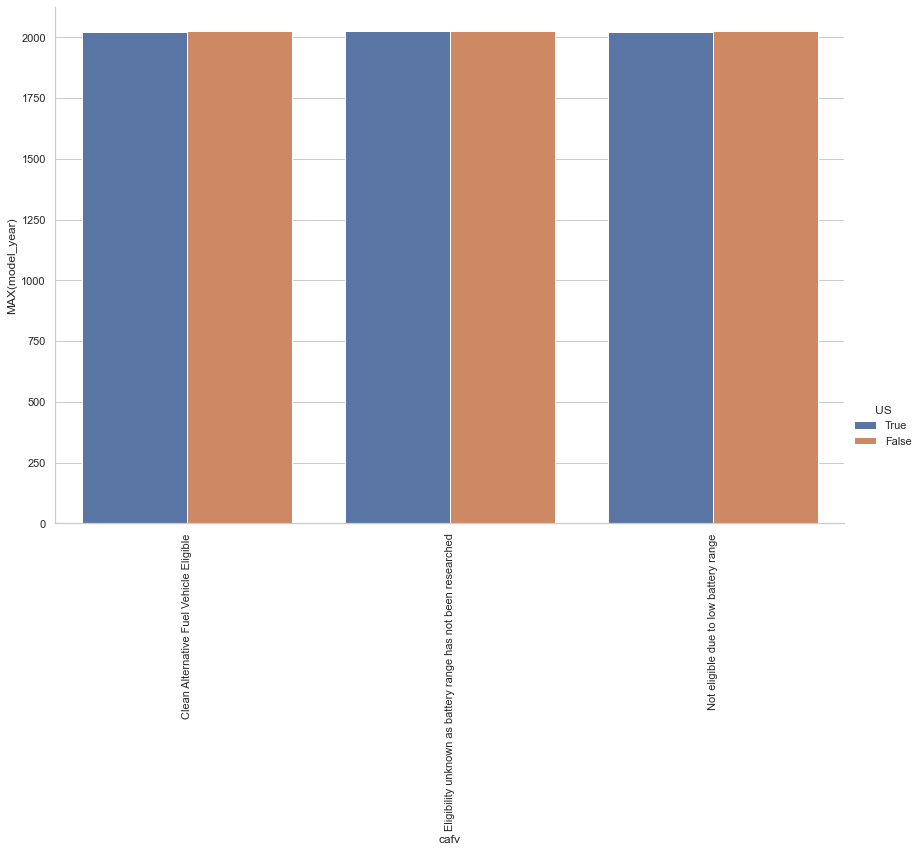

In [50]:
for q in bottom_k_sharing:
    a,m,f = q[0]
    visualize_query(a,m,f)

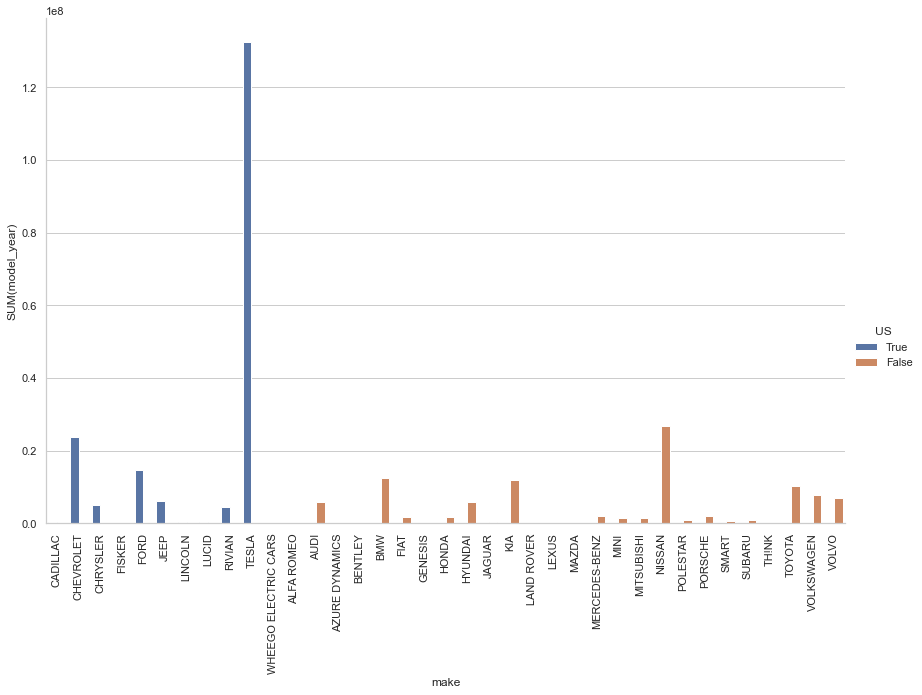

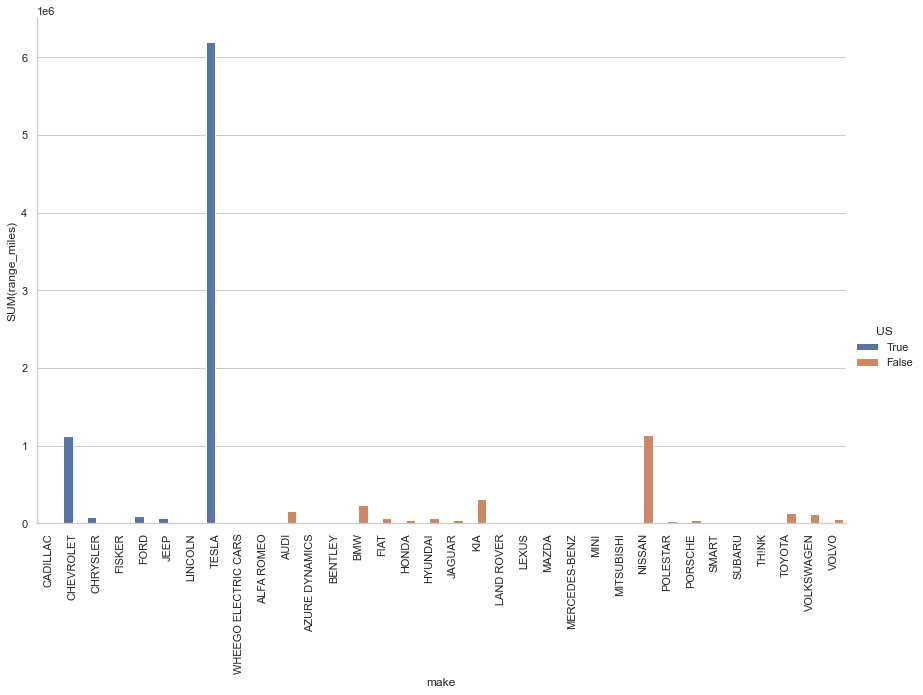

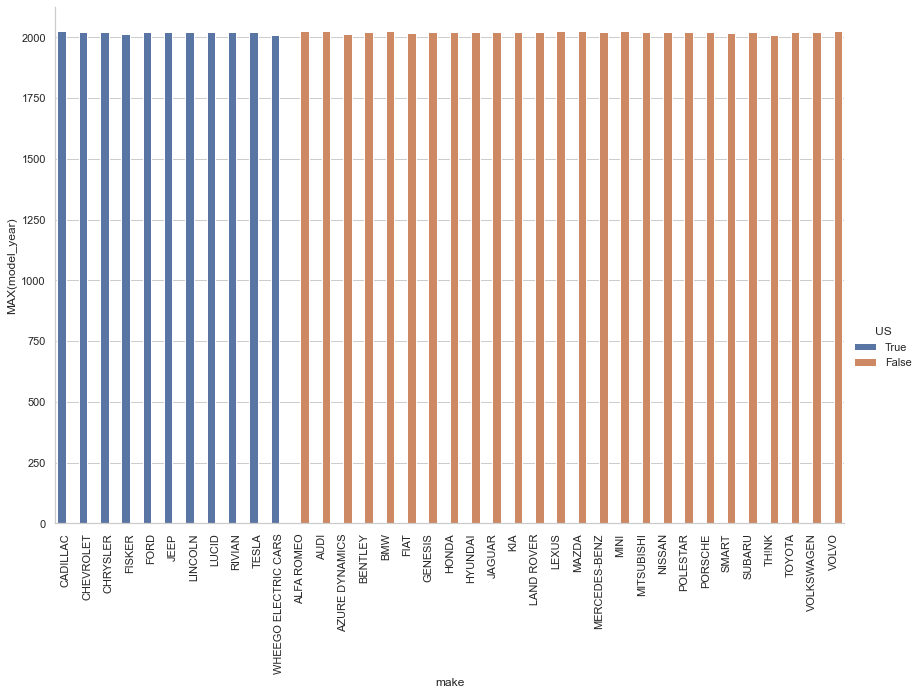

In [51]:
for q in top_k_pruning_and_sharing:
    a,m,f = q[0]
    visualize_query(a,m,f)

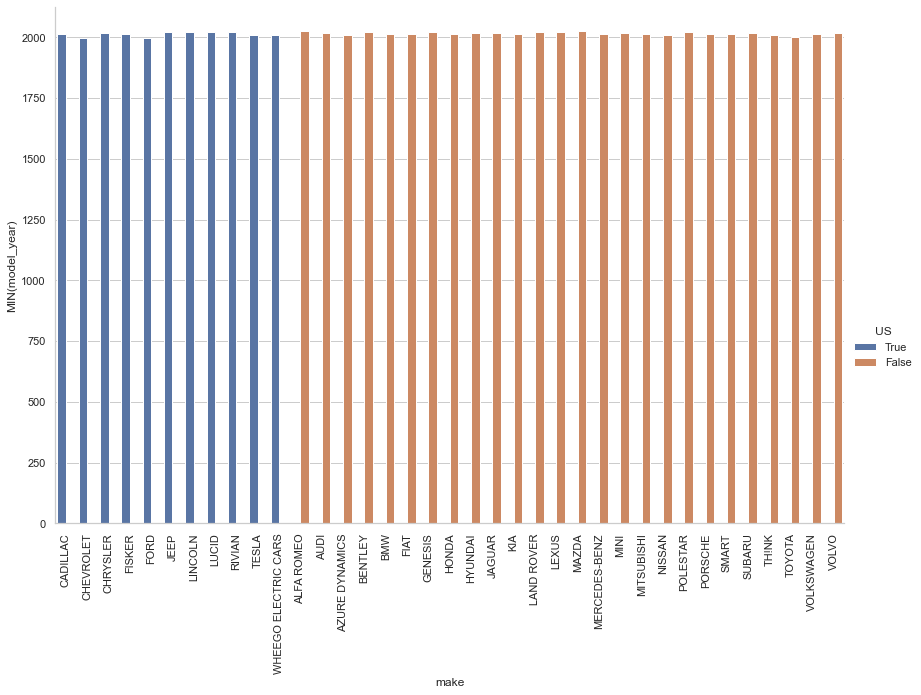

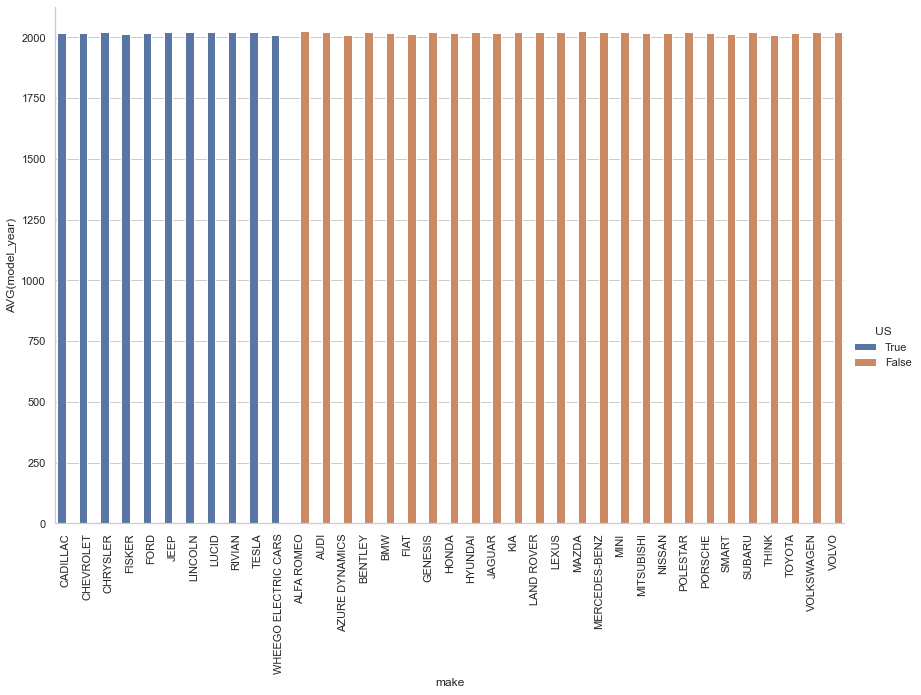

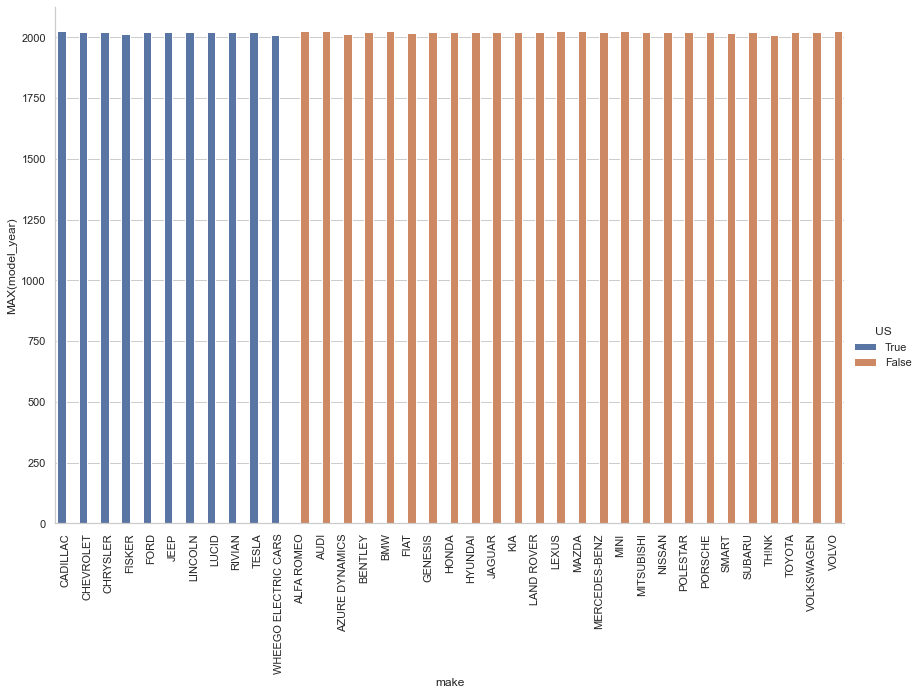

In [52]:
for q in bottom_k_pruning_and_sharing:
    a,m,f = q[0]
    visualize_query(a,m,f)